# Used Car Sale Auction Prices
By Sky Reznik, John Lackey and Kevin Abatto
2025-04-22

Import packages

In [ ]:
import pandas as pd; # type: ignore
import numpy as np; # type: ignore
from holoviews.operation import histogram;
from sklearn.preprocessing import OneHotEncoder; # type: ignore
from sklearn.model_selection import train_test_split;
from sklearn.linear_model import LinearRegression;
from sklearn.metrics import mean_squared_error, r2_score;
import os;

Import data

In [512]:
# Load CSV into a pandas dataframe
shared_file_path = './kaggle_datasets/car_prices.csv'
# line 408,163 - "Model" field contains a comma (SE PZEV w/Connectivity, Navigation) - specify quotechar='"'
# This tells Pandas to treat anything inside double quotes as a single field, even if it contains commas.
#      solution provided by ChatGPT
df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')

/var/folders/mv/9l39xh61679g3fk2_5cyrrzh0000gn/T/ipykernel_49361/2980136107.py:6: DtypeWarning: Columns (8,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(shared_file_path, quotechar='"', on_bad_lines='skip')


Now we need at append the MSRP of these cars. By using a data set that had make, model, year, transmission, etc. we can match the values and add in the MSRP.

We have excluded trim and chosen the lowest price match to avoid over saturating the data with multiple trim levels at different prices of the same vehicle.

In [513]:
# Load datasets
msrp = pd.read_csv('MSRP.csv')

# Standardize column names and values
msrp.rename(columns={
    'Make': 'make',
    "Model": "model",
    "Year": "year",
    "Transmission Type": "transmission"
}, inplace=True)

msrp['transmission'] = msrp['transmission'].str.lower()

# Create matching keys
df['match_key'] = (
    df['year'].astype(str).str.lower() + '_' + 
    df['make'].str.lower() + '_' + 
    df['model'].str.lower() + '_' + 
    df['transmission'].str.lower()
)

msrp['match_key'] = (
    msrp['year'].astype(str).str.lower() + '_' + 
    msrp['make'].str.lower() + '_' + 
    msrp['model'].str.lower() + '_' + 
    msrp['transmission'].str.lower()
)

# Sort by MSRP (ascending) and keep first (min) for each match_key
msrp_min_row = msrp.sort_values('MSRP').drop_duplicates('match_key', keep='first')

# Merge with original car data (keeping all car rows but adding MSRP where matched)
car_with_msrp = df.merge(
    msrp_min_row[['match_key', 'MSRP']],  # Only keep needed columns
    on='match_key',
    how='left'
)

# Drop the temporary key column
car_with_msrp = car_with_msrp.drop(columns=['match_key'])

# Save the merged DataFrame to a new CSV file
car_with_msrp.to_csv('car_prices_with_msrp.csv', index=False)

# Data Cleaning
__Done__
1) Remove any row with missing data with df.dropna()
2) One-Hot encode ['transmission'] to ['automatic_trans'] 0 /1 (double check unique vals)
3) Simplify ['body'] (collapse all 85 body types to 9 types)
4) Convert ['saledate']
5) Age of car (from ['saledate'])
6) Drop negative age cars
7) Drop unessecary or redundant columns
8) Make 'condition' numeric


In [514]:
# now we can use the car_prices_with_msrp DataFrame
df = pd.read_csv('car_prices_with_msrp.csv', low_memory=False)
# Remove 'Unamed: 16' column
df.drop('Unnamed: 16', axis=1, inplace=True)

1 - Remove rows that have missing values


In [515]:
df.dropna(inplace=True)

2 - One-hot encode the 'transmission' column


In [516]:
print(df['transmission'].unique())
df['auto_transmission'] = np.where(df['transmission'].str.contains('automatic', case=False), 1, 0)

['automatic' 'manual']


3 - 'One-hot encode' the 'body' column (count 85 unique values --> reduce to 8)


In [517]:
# ['suv' 'sedan' 'convertible' 'coupe' 'wagon' 'hatchback' 'truck' 'minivan' 'van']
df['body_type'] = np.nan
df['body_type'] = np.where(df['body'].str.contains('minivan', case=False), 'minivan', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('sedan', case=False), 'sedan', df['body'])
df['body_type'] = np.where(df['body'].str.contains('wagon', case=False), 'wagon', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('coupe', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('koup', case=False), 'coupe', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('convertible', case=False), 'convertible', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('hatchback', case=False), 'hatchback', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains(r'\bvan\b', case=False), 'van', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('truck', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('cab', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('crew', case=False), 'truck', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('suv', case=False), 'suv', df['body_type'])
df['body_type'] = np.where(df['body'].str.contains('Minivan', case=False), 'minivan', df['body_type'])

# Numerical mapping for body types
size_mapping = {
    'convertible': 0,
    'coupe': 1,
    'hatchback': 2,
    'sedan': 3,
    'wagon': 4,
    'suv': 5,
    'minivan': 6,
    'truck': 7,
    'van': 8
}

df['body_size'] = df['body_type'].map(size_mapping)

4 - Converting 'saledate' to datetime (solution provided by ChatGPT)

In [518]:
# Handle invalid or unexpected values in the 'saledate' column
# Extract just the date part (e.g., "Dec 16 2014") before conversion
df['saledate'] = pd.to_datetime(
    df['saledate'].str.extract(r'(\w{3} \d{2} \d{4})')[0], 
    format='%b %d %Y', 
    errors='coerce'
)

5 - Create a new column 'car_age'

In [ ]:
df['car_age'] = np.where(df['saledate'].notna(), df['saledate'].dt.year - df['year'], np.nan)

6 - Some car ages are negative (which is not possible) because a 2015 model year can exist in 2014 and subsequently be sold

In [520]:
# For rows with values less than 0, drop rows
print("Number of negative car ages dropped: ", df[df['car_age'] < 0].shape[0])
df.drop(df[df['car_age'] < 0].index, inplace=True)
# Drop old columns 'transmission' & 'body'
df.drop(['transmission', 'body'], axis=1, inplace=True)

Number of negative car ages dropped:  135


7 - Drop unessecary or redundant columns

In [521]:
df.drop(['year', 'trim', 'vin', 'color', 'interior', 'saledate', 'body_type'], axis=1, inplace=True)

8 - Make 'condition' numeric

In [522]:
df['condition'] = pd.to_numeric(df['condition'], errors='coerce')

# Exploratory Data Analysis

First, let's learn more about our data now that is has been cleaned!

In [523]:
print(df.columns.unique())

Index(['make', 'model', 'state', 'condition', 'odometer', 'seller', 'mmr',
       'sellingprice', 'MSRP', 'auto_transmission', 'body_size', 'car_age'],
      dtype='object')


## DataFrame Features Overview

### 1. make
- **Description**: The manufacturer/brand of the vehicle
- **Type**: Categorical (e.g., Toyota, Ford, Honda)
- **Potential Use**: Grouping vehicles by brand for analysis

### 2. model
- **Description**: The specific model name of the vehicle
- **Type**: Categorical (e.g., Camry, F-150, Escape)
- **Potential Use**: Detailed vehicle identification when combined with make

### 3. state
- **Description**: The geographical state where the vehicle is located/registered
- **Type**: Categorical (e.g., CA, TX, NY)
- **Potential Use**: Regional price analysis or demand patterns

### 4. condition
- **Description**: The physical/mechanical condition of the vehicle
- **Type**: Numerical (0-5)
- **Potential Use**: Key factor in pricing models

### 5. odometer
- **Description**: The mileage reading showing how many miles the vehicle has traveled
- **Type**: Numerical (continuous)
- **Potential Use**: Strong predictor of vehicle value and wear

### 6. seller
- **Description**: The party selling the vehicle 
- **Type**: Categorical
- **Potential Use**: Analyzing price differences between seller types

### 7. mmr (Manheim Market Report)
- **Description**: Wholesale market valuation of the vehicle caluculated and updated every 24 hours
- **Type**: Numerical (currency USD)
- **Potential Use**: Benchmark for comparing selling prices

### 8. sellingprice
- **Description**: The actual auction sale price of the vehicle
- **Type**: Numerical (currency USD)
- **Potential Use**: Target variable for price prediction models

### 9. MSRP (Manufacturer's Suggested Retail Price)
- **Description**: The original new vehicle price recommended by manufacturer
- **Type**: Numerical (currency USD)
- **Potential Use**: Baseline for depreciation calculations

### 10. auto_transmission
- **Description**: Whether the vehicle has automatic transmission
- **Type**: Boolean (0/1)
- **Potential Use**: Analyzing price differences between transmission types

### 11. body_size
- **Description**: The size classification of the vehicle
- **Type**: Ordinal numerical (1=smallest to 8=largest)
- **Potential Use**: Market segment analysis

### 12. car_age
- **Description**: The age of the vehicle in years
- **Type**: Numerical (discrete)
- **Potential Use**: Key factor in depreciation models

In [524]:
df.head(4)

,make,model,state,condition,odometer,seller,mmr,sellingprice,MSRP,auto_transmission,body_size,car_age
3,Volvo,S60,ca,4.1,14282.0,volvo na rep/world omni,27500,27750,33300.0,1,3,0.0
12,Ford,Fusion,ca,2.0,5559.0,enterprise vehicle exchange / tra / rental / t...,15350,12000,22500.0,1,3,0.0
20,Chevrolet,Impala,ca,1.9,14538.0,enterprise vehicle exchange / tra / rental / t...,24300,7200,27060.0,1,3,0.0
26,Volvo,XC70,ca,4.2,16506.0,volvo na rep/world omni,32100,32500,35400.0,1,4,0.0


In [525]:
len(df.make.unique())
df.make.value_counts()

make
Infiniti         11997
Chevrolet         5712
Dodge             5574
Kia               4032
Chrysler          4007
Ford              3840
Lexus             2242
Pontiac           1918
Hyundai           1363
Nissan            1315
GMC               1187
Acura             1123
Mazda              912
Mercedes-Benz      807
Toyota             806
Buick              791
Cadillac           773
Lincoln            669
Volkswagen         652
Subaru             629
Honda              627
Suzuki             611
BMW                594
Volvo              574
Mitsubishi         556
Scion              296
Oldsmobile         213
Land Rover         194
Audi               121
HUMMER             105
Saab                52
Porsche             20
Bentley             15
Plymouth             9
Rolls-Royce          4
Aston Martin         2
FIAT                 2
Maserati             1
Ferrari              1
Name: count, dtype: int64

MMR is provided in the dataset... it is the "Mannheim Market Report", an estimation of a car's selling value, which is updated nightly, and trained on millions of auction transactions. For our auction data, we can assume it is a sellers goal to surpass the MMR in the auction.

Therefore, a relevant one-hot-encoding would be if the `sellingprice` > `mmr`. While it is good practice to not have redundant columns; ones which can be inferred from the data, a binary column `sold_above_mmr` would be highly useful for geographical visualizations and determining which sellers or states outpreform their estimated MMR.

We will create it below:


In [526]:
# ensure mmr and sellingprice are numeric
df['mmr'] = pd.to_numeric(df['mmr'], errors='coerce')
df['sellingprice'] = pd.to_numeric(df['sellingprice'], errors='coerce')
df['sold_above_mmr'] = np.where(df['sellingprice'] > df['mmr'], 1, 0 )
df[['sellingprice', 'mmr', 'sold_above_mmr']].head(4)

,sellingprice,mmr,sold_above_mmr
3,27750,27500,1
12,12000,15350,0
20,7200,24300,0
26,32500,32100,1


Let's visualize selling prices for a baseline, and take the 95th percentile

<Axes: xlabel='sellingprice', ylabel='Count'>

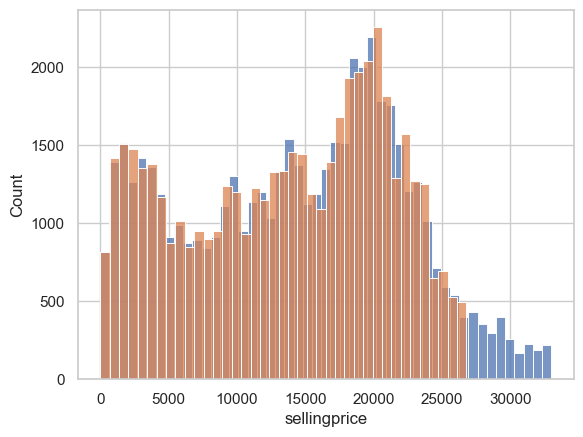

In [537]:
sns.histplot(data=df, x='sellingprice')
threshold = df['sellingprice'].quantile(0.95)
df = df[df['sellingprice'] <= threshold]
sns.histplot(data=df, x='sellingprice')

# Data Visualization
Plot 'mmr' v. 'sellingprice'


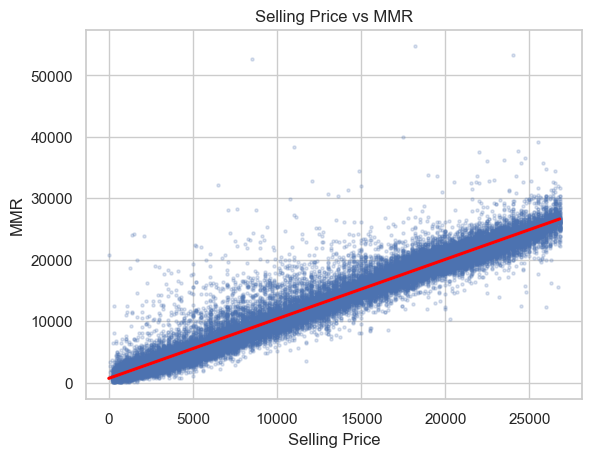

In [539]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.scatter(df['sellingprice'], df['mmr'], alpha=0.2, s=5)  
sns.regplot(x='sellingprice', y='mmr', data=df, scatter=False, color='red')  
plt.title('Selling Price vs MMR')  
plt.xlabel('Selling Price')  
plt.ylabel('MMR') 
plt.show()

# Using features to predict selling price
List of numeric features:
1. year
2. condition
3. odometer
4. auto_transmission
5. car_age
6. MSRP

In [540]:
df_predictor = df[['condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP', 'body_size']]
df_target = df['sellingprice']
X = df_predictor
y = df_target

# Split into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=39)
# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Make predictions and evaluate the model

In [541]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(Y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2}")

Mean Squared Error (MSE): 10032451.947829574
R^2 (coefficient of determination): 0.8152215036391292


Plot predictions vs actual selling

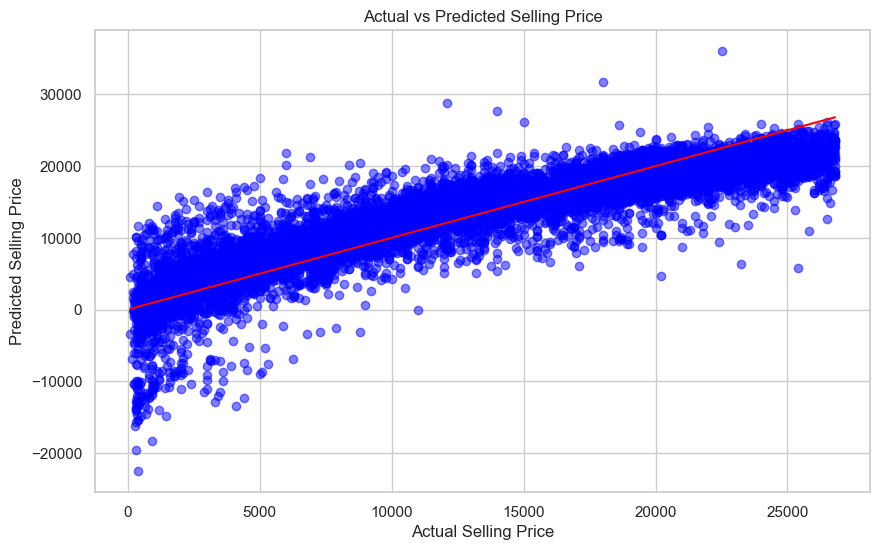

In [542]:
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred, alpha=0.5, color='blue') 
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=1.5) # Perfect prediction line
plt.xlabel('Actual Selling Price') 
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.show()

In [543]:
df_predictor = df[['condition', 'odometer', 'auto_transmission', 'car_age', 'MSRP', 'body_size']]
df_target = df['sellingprice']
X = df_predictor
y = df_target

# Split into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=39)
# Train the Linear Regression model
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [544]:
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

r2 = r2_score(Y_test, y_pred)
print(f"R^2 (coefficient of determination): {r2}")

Mean Squared Error (MSE): 10032451.947829574
R^2 (coefficient of determination): 0.8152215036391292


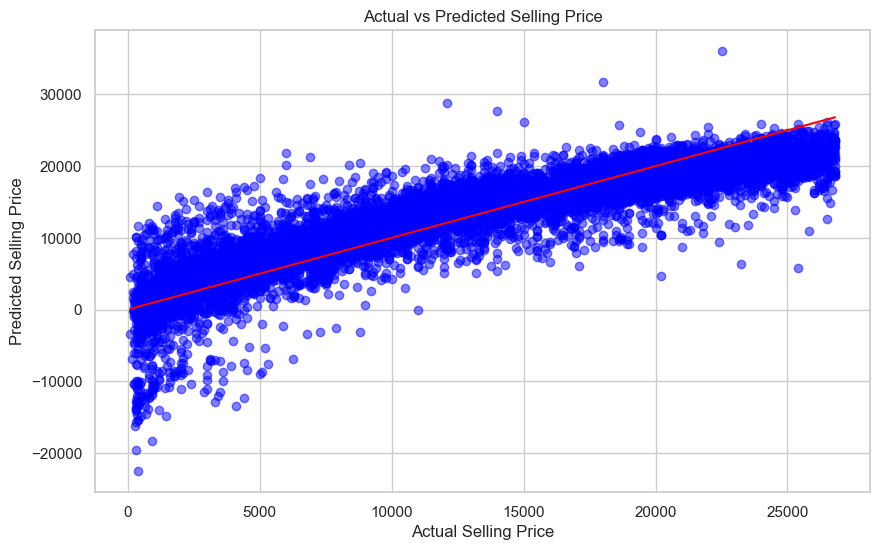

In [545]:
plt.figure(figsize=(10,6))
plt.scatter(Y_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linewidth=1.5) # Perfect prediction line
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Selling Price')
plt.show()